In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from time import time
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import splitfolders
import shutil
import time

### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Projecto 3 parte 1: Red CNN


Profesora: María Auxiliadora Mora

Estudiantes:
 1. Pablo Alberto Muñoz Hidalgo
 2. Luis Andrés Rojas Murillo

Entregables: Un archivo en Jupyter ( .IPYNB ). 

Modo de trabajo: En parejas.

---

Objetivo: 

Problema:  

### Sección de carga, normalización y exploración los datos.

In [9]:
#reduce the images quality to 3x32x32
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Número de imágenes de entrenamiento:  25479
Número de imágenes de prueba:  800



IMAGEN A RESOLUCION 48x48


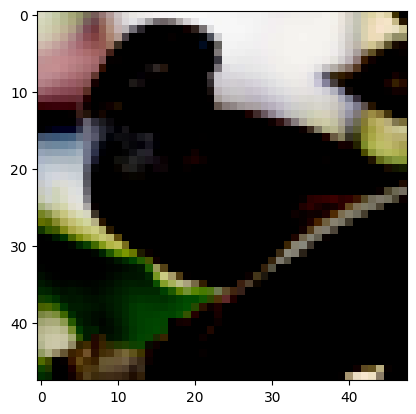

In [10]:
# Define la ruta a la carpeta que contiene las imágenes
ruta_imagenes = "birds"

# Carga de los datos de la ruta imagenes, crea un set de training con la carpeta train, luego uno de testing con la carpeta test
# y por último uno de validación con la carpeta val
testset = datasets.ImageFolder(ruta_imagenes + "/test", transform=transform)
trainset = datasets.ImageFolder(ruta_imagenes + "/train", transform=transform)


# Se definen objetos para la carga de los datos en mini batches (DataLoader),
# que combinan y barajan el conjunto de datos. 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

#Normaliza los datos para ser procesados

# Imprime el número de imágenes y clases en el conjunto de datos
print("Número de imágenes de entrenamiento: ", len(trainset))
print("Número de imágenes de prueba: ", len(testset))

#imprime lcualquier imagen del set de prueba
print('\n\n\nIMAGEN A RESOLUCION 48x48')
plt.imshow(trainset[0][0].permute(1, 2, 0))
plt.show()


### Analisis de las imagenes 
Se concluye que el conjunto de imagenes para la prueba es una coleccion de imagenes representativas de especies animales clasificadas según su especie en directorios especificos los cuales se utilizarán para una clasificcaion automática a travéz del perceptrón.

### Estadísticas

In [11]:
# Genera estadísticas del conjunto de datos
etiquetas = [etiqueta for _, etiqueta in testset]
etiquetas_dict = {clase: etiquetas.count(indice_clase) for indice_clase, clase in enumerate(testset.classes)}

# Estadísticas 1: Cantidad de registros por clase
# Se almacena en un diccionario la clase con su respectiva incidencia en el conjunto de datos
incidencias = {clase: etiquetas.count(indice_clase) for indice_clase, clase in enumerate(testset.classes)}



##### Distribución de imagenes por cada clase 

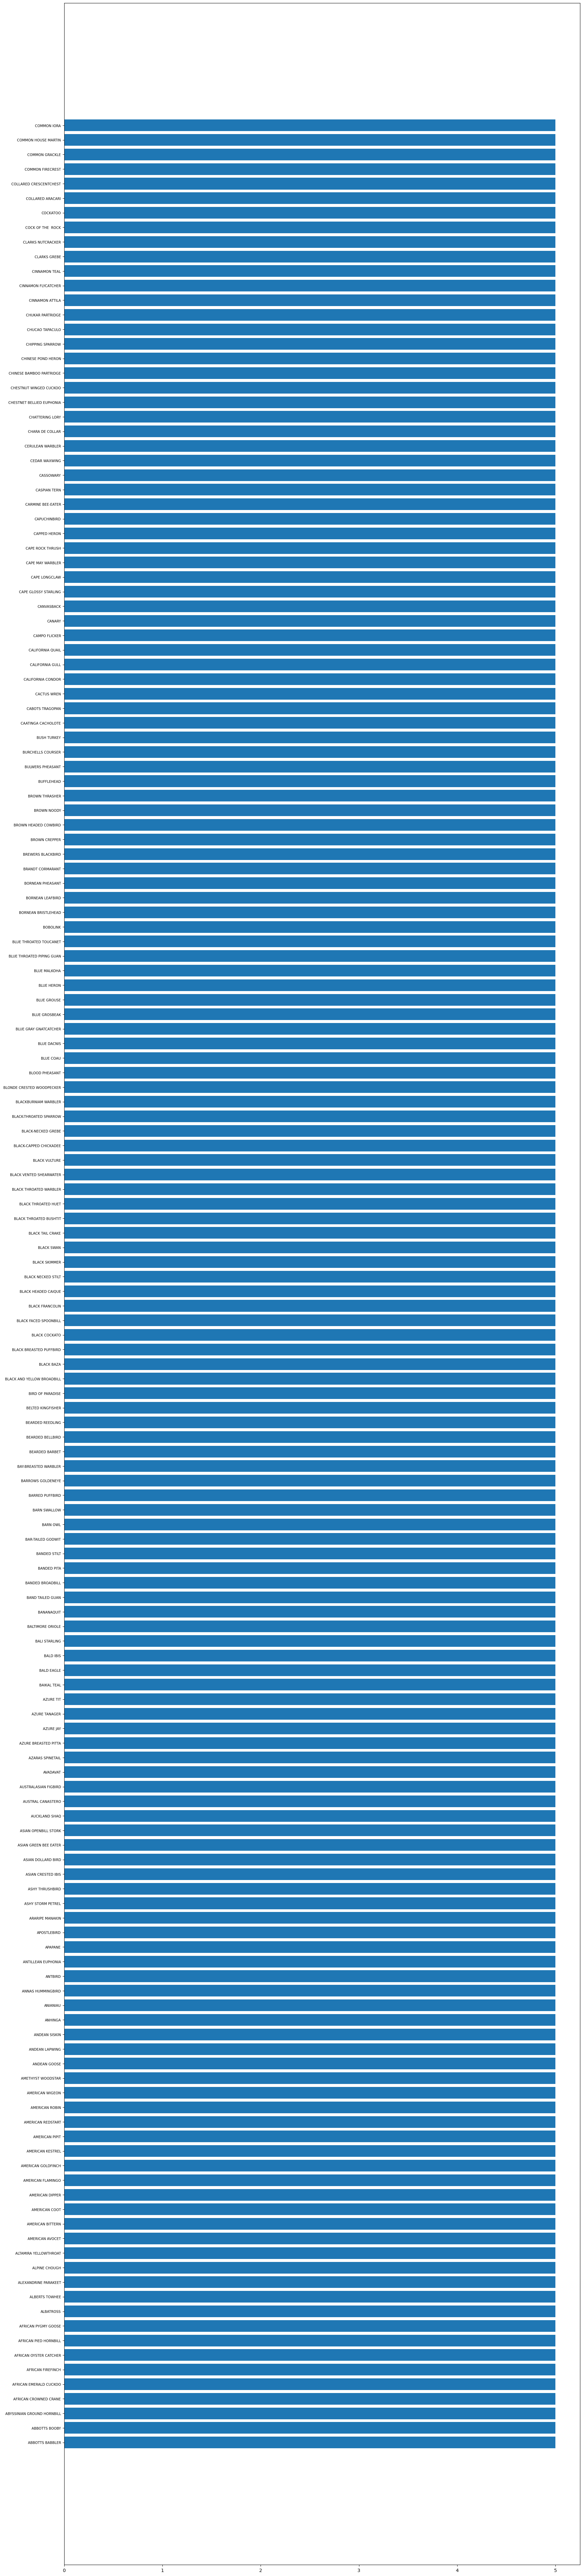

                          Clase  Incidencia
0               ABBOTTS BABBLER           5
1                 ABBOTTS BOOBY           5
2    ABYSSINIAN GROUND HORNBILL           5
3         AFRICAN CROWNED CRANE           5
4        AFRICAN EMERALD CUCKOO           5
..                          ...         ...
155      COLLARED CRESCENTCHEST           5
156            COMMON FIRECREST           5
157              COMMON GRACKLE           5
158         COMMON HOUSE MARTIN           5
159                 COMMON IORA           5

[160 rows x 2 columns]


In [12]:
# se grafican las incidencias con los nombres de las claces en forma vertical y con una funete muy pequeña
#Do a graphic for 525 classes
plt.figure(figsize=(20, 100))
plt.barh(list(incidencias.keys()), list(incidencias.values()))
plt.yticks(fontsize=7.5)
plt.show()


#haga una tabla con las incidencias de cada clase usando pandas
df = pd.DataFrame(incidencias.items(), columns=['Clase', 'Incidencia'])
print(df)   


### Definición de la red convolucional.

In [13]:
print('\n\n\nTamaño y datos generales del trainloader 48x48')
print(trainloader.dataset[-1][0].shape)
#print('\n\n\nTamaño y datos generales del trainloader 128x128')
#print(trainloader_hd.dataset[-1][0].shape)





Tamaño y datos generales del trainloader 48x48
torch.Size([3, 48, 48])


In [14]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flat = nn.Flatten()
        
        self.fc3 = nn.Linear(32 * 24 * 24, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        
        #Cantidad de clases 90
        self.fc4 = nn.Linear(512, 525)
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

model = CNN()
print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Iteraciones
epochs = 25
results = []
#Print the time it takes to run it
start_time = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            acc += (torch.argmax(outputs, 1) == labels).float().sum()
            count += len(labels)
        acc /= count
    results.append([(epoch+1),loss.detach().numpy(), ((acc/count).detach().numpy()*100)])
    print("Epoch: {}/{}.. ".format(epoch+1, epochs), 
            "Training Loss: {:.3f}.. ".format(loss.detach().numpy()),
            "Test Accuracy: {:.3f}%".format((acc/count).detach().numpy()*10000))

print("\n--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'cifar10_model.pth')


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=18432, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=525, bias=True)
)
Epoch: 1/1..  Training Loss: 4.806..  Test Accuracy: 0.313%

--- 114.45624709129333 seconds ---


Muestra de los resultados obtenidos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

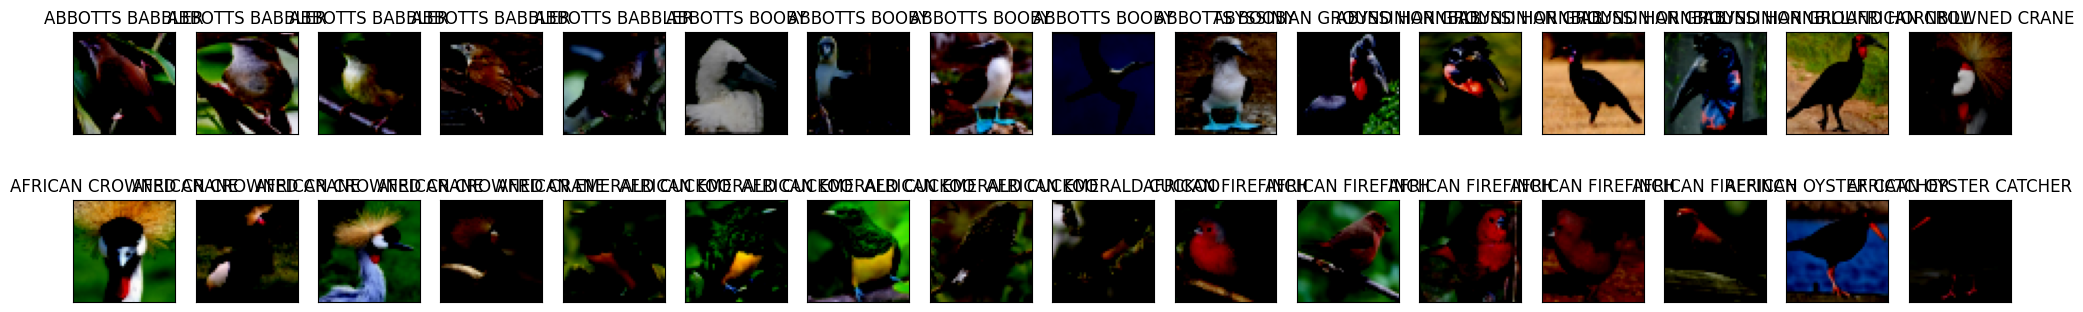

In [15]:
#Clases asociadas a las imágenes.
classes = testloader.dataset.classes

dataiter = iter(testloader)
images, labels = next(dataiter)


# Se muestran las imágenes de prueba, muestra 100 imagenes y sus predicciones de manera ordenada en una tabla
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
plt.show()

## Analisis de resultados

Resultados con imagenes de 48x48

   Época % Perdida  % Exactitud
0      1  4.805947       0.3125
Accuracy:  0.31250001484295353
Precision:  0.0031250001484295353
Recall:  0.31250001484295353
F1:  0.0061881191058010595


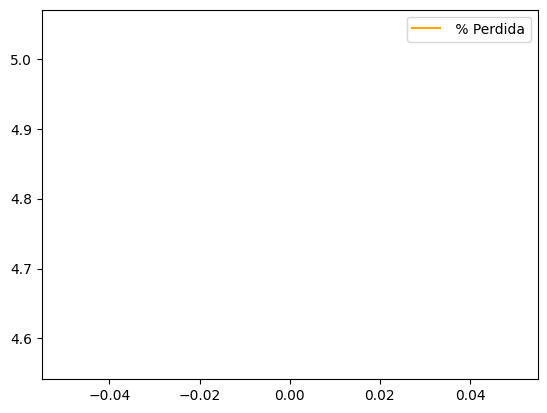

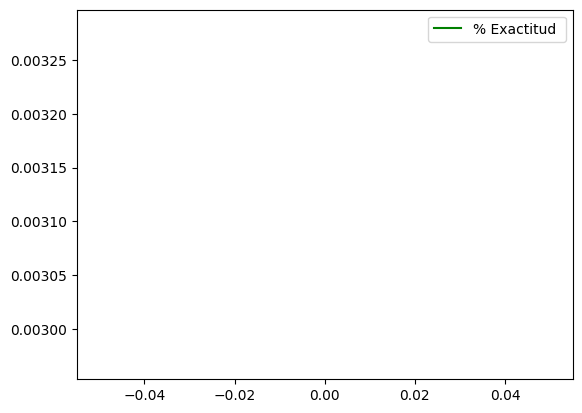

In [16]:

#se hace una tabla con las columnas marcadas con los tensores de loss y accuracy
df = pd.DataFrame(results, columns=['Época', '% Perdida', '% Exactitud'])
#multiplica la exactitud por 1000
df['% Exactitud'] = df['% Exactitud'] * 100
print(df)
#se calcula el recall
recall = df['% Exactitud'].mean()

#impresion de datos: Accuracy, Precision, Recall y F1.

print('Accuracy: ', (acc/count).detach().numpy()*10000)
print('Precision: ', results[-1][2])
print('Recall: ', recall)


#se calcula la f1
f1 = 2 * (recall *  results[-1][2]) / (recall +  results[-1][2])
print('F1: ', f1)



#se grafican los tensores de loss y accuracy por separado
results = np.array(results)
plt.plot(results[:, 1], label=' % Perdida', color='orange')
plt.legend()
plt.show()

results = np.array(results)
plt.plot(results[:, 2], label='% Exactitud ', color= 'green')
plt.legend()
plt.show()



#### Proposicion de mejoras

1. Buscar un método de optimizar estos algoritmos para disminuir el consumo de recursos y minimizar la duracion de la ejecución
2. Se puede aumentar el numero de epocas para asi poder permitir al perceptron desarrollar mejor sus habilidades 

#### Cambios aplicados para la mejora del flujo 

1. Se disminuyó el tamaño de la muesta a un numero mucho menor de clases para clasificar lo que alivió fuertemente las necesidades de procesamineto sin embargo si se comprobó que el algoritmo es capaz de clasificar la colección de imagenes completa. 
2. Se disminuyo la resolucion de las imagenes que compuso un claro avance para el aumento de la velocidad de procesamiento aunque afectando la efectividad de los analisis 
3. Se aplicaron corridas con diferente cantidades de épocas de procesamineto sin embargo quedó demostrado que entre más épocas se aplique aumenta la fiabilidad del modelo.

Todas esta endidas fueron parte de las experimentaciones realizadas.

## Conclusiones


1. La configuracion de los múltiples paramentros de analisis es crucial para el correcto funcionamiento del mecanismo del perceptrón.
2. La capcidad del preceptrón de analizar las imagenes no presenta relación a la definición con la que cuente la imagen que se esta analizando  
3. Entre mayor sea la cantidad de epocas, mejores resultados logra concibir el mecanismo ya que él mismo se auto corrrige y aumenta la presición 
4. Estos mecanimos son altamente pesados anivel de procesamineto y es muy importante contar con equipos de altas prestaciones para realizarlos.

## Referencias
[1] Krajewski, J. (2020). PyTorch layer dimensions: what size and why?. Recuperado de https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

[2] Recommended approach for saving a model. <https://pytorch.org/docs/stable/notes/serialization.html>

[3] Krizhevsky, A., Nair, G, & Hinton, G. The CIFAR-10 dataset (n.d.).  Recuperado de https://www.cs.toronto.edu/~kriz/cifar.html

[4] Tam, Adrian (2023). Building a Convolutional Neural Network in PyTorch. Recuperado de https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/